# Reference
All of this is from [here](https://www.overleaf.com/read/sndwwjwxfhpy)

In [1]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants

# Parameters

In [2]:
# Uncompensated quality factor
Q = 0.703

# Resonant frequency of the driver in a box
fsc = 31

# The moving mass and air load
m = 0.0424

In [3]:
# Calculate some other variables

# The spring constant
ks = m*((2*np.pi*fsc)**2)

# The damping constant
kf = np.sqrt(ks*m) / Q
ks, kf

(1608.6033950741894, 11.747679612740892)

Total Data Length: 239616 , Sample Rate: 48000


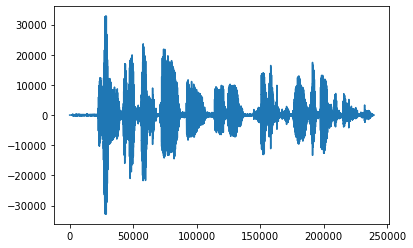

In [4]:
# Get the original data

sample_rate, input_data = wavfile.read('./samples/test.wav')
print("Total Data Length:", len(input_data), ", Sample Rate:",sample_rate)

num_seconds = 10

# Use this for sample data

# input_data = [0,1,2,3,1,2,3,0]
# sample_rate = 80
# num_seconds = 0.1

beg = 0
end = beg + int(sample_rate * num_seconds)

if (end > len(input_data)):
    end = len(input_data)

input_data = input_data[beg:end]

wavfile.write("original_sound.wav", sample_rate, input_data)

plt.plot(input_data)

In [5]:
def center(arr):
#     n = int(sample_rate / 20)
    n = 2
    n_terms_ago = 0
    continuous_sum = 0
    arr_centered = []
    arr_averages = [] # just for testing
    for i in range(len(arr)):
        last_n_index = i % n
        continuous_sum += arr[i]
        if i >= n:
            continuous_sum -= arr[i-n]

        last_n_avg = continuous_sum / n
        arr_averages.append(last_n_avg)
        arr_centered.append(arr[i] - last_n_avg)
    
    return arr_centered

# plt.plot(Vos)
# plt.plot(Vos_centered)

In [6]:
def filt(arr, order=6, frequency=10, filter_type="hp"):
    return arr

    Wn = 2*constants.pi*frequency
    sos = signal.butter(order,Wn,filter_type,fs=sample_rate, output="sos")
    filtered = final = signal.sosfilt(sos, arr)    
    
    return final

def normalize(input_data, output_data):
    max_original = np.amax(np.absolute(input_data))
    max_values = np.amax(np.absolute(output_data))
    scalar = (max_original / max_values)
    print("Scalar:", scalar)
    
    for i in range(len(output_data)):
        output_data[i] = scalar * output_data[i]

    return output_data

In [7]:


# NOTE: this should not be beg, as input_data has been adjusted to include only the select values
time = 0
length = end - beg

first_integral = 0
second_integral = 0

# Vis = filt(input_data, order=4, frequency=120, filter_type="lowpass")
Vis = center(input_data)
Vfs = []
Vss = []

first_integrals = []
second_integrals = [] # this is really the integral of the butterworth_first_integrals

while time<length:
    first_integrals.append(first_integral)
    first_integral += Vis[time]
    time += 1

# adjusted_first_integrals = filt(first_integrals, 6, 10, "highpass")
adjusted_first_integrals = center(first_integrals)

time = 0

while time<length:
    Vfs.append((kf/m) * adjusted_first_integrals[time])
    time += 1
    
time = 0

while time<length:
    second_integrals.append(second_integral)
    second_integral += adjusted_first_integrals[time]
    time += 1

# adjusted_second_integrals = filt(second_integrals, 6, 10, "highpass")
adjusted_second_integrals = center(second_integrals)
    
time = 0

while time<length:
    Vss.append((ks/m) * adjusted_second_integrals[time])
    time += 1

# Vfs and Vss are orders of magnitude more significant the original signal. So, we want to standardize the values so that they are on about the same scale
input_highpassed = filt(input_data, order=2, frequency=1, filter_type="highpass")

# treble_gain = np.amax(np.abs(Vfs + Vss)) / np.amax(np.abs(Vis))
treble_gain = np.float64(1.0)

Vss = filt(Vss, order=2, frequency=20, filter_type="highpass")

Vfs = Vfs / np.float64(sample_rate)
Vss = Vss / np.float64(sample_rate*sample_rate)

# Vss = [0 for i in range(len(Vss))]
# Vfs = [0 for i in range(len(Vfs))]

print(treble_gain, type(treble_gain))

Vos = (Vis - (Vfs / treble_gain) - (Vss / treble_gain)) 
# Vos = filt(input_data, order=2, frequency=20, filter_type="highpass")

1.0 <class 'numpy.float64'>


Scalar: 7.200574444060044
Scalar: 1.9567025435018455


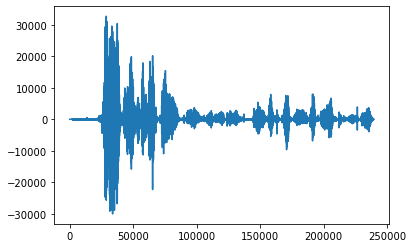

In [8]:
Vos = normalize(input_data, Vos)
Vos_centered = center(Vos)
Vos_centered = normalize(input_data, np.array(Vos_centered))
plt.plot(Vos)

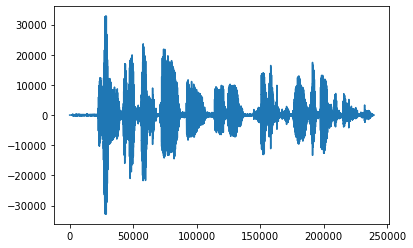

In [9]:
# plt.plot(signal.sosfilt(sos, input_data))
plt.plot(input_data)

In [10]:
wavfile.write("output.wav", sample_rate, Vos)
wavfile.write("original_sound.wav", sample_rate, input_data)

input_centered = normalize(input_data, np.array(center(input_data)))
wavfile.write("input_sound_centered.wav", sample_rate, input_centered)

Scalar: 7.182595352915388


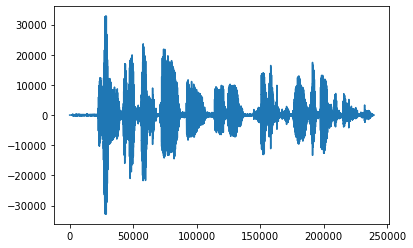

In [11]:
plt.plot(input_highpassed)
# input_highpassed = normalize(input_data, input_highpassed)
# wavfile.write("input_highpassed.wav", sample_rate, input_highpassed)

NameError: name 'Vos_averages' is not defined

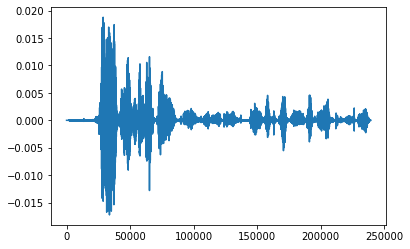

In [12]:
plt.plot(Vss)
opposite_averages = [-3.4 * Vos_averages[i] for i in range(len(Vos_averages))]

plt.plot(opposite_averages)

In [ ]:
plt.plot(Vfs)
wavfile.write("vfs.wav", sample_rate, Vfs)

In [ ]:
plt.plot(Vis)